In [69]:
from pyscf import gto, scf, mcscf
import matplotlib as mpl
import matplotlib.pyplot as plt


Geometry from [Tanaka & Morino, _J. Mol. Spect._, **1970**, *33*, 538-551](https://www.sciencedirect.com/science/article/abs/pii/0022285270901487)

> O-O bond length = 1.272 Å  
> O-O-O angle = 116.78°

In [2]:
geom = """
O1  0.0000  0.0000  0.0000;
O2  1.0833  0.6667  0.0000;
O3 -1.0833  0.6667  0.0000;
"""

Ahlrics basis sets, from double to quadruple zeta and without/with diffuse functions

In [47]:
basis_sets = {"SVP": "def2-svp",
              "SVPD": "def2-svpd", 
              "TZVP": "def2-tzvp",
              "TZVPD": "def2-tzvpd",
              "QZVP": "def2-qzvp",
              "QZVPD": "def2-qzvpd"}

In [51]:
results = {}

In [52]:
for name, basis_set in basis_sets.items():
    mol = gto.M(atom=geom, basis=basis_set).build()
    rhf = scf.RHF(mol).density_fit()
    rhf.kernel()
    results[name] = {"mol": mol, "RHF": rhf}

converged SCF energy = -224.057022451971
converged SCF energy = -224.074631790138
converged SCF energy = -224.351710462103
converged SCF energy = -224.353165062652
converged SCF energy = -224.361977544458
converged SCF energy = -224.362624105908


How does the number of basis functions affect the energy?
* Going from double -> triple zeta improves the energy substantially. Triple -> quadruple zeta is a smaller improvement
* The greater number of basis functions in the parent basis set, the lesser the effect of adding diffuse functions

In [53]:
for name, result in results.items():
    n_basis = len(result["mol"]._basis["O1"]) * 3
    e_rhf = result["RHF"].energy_tot()
    print(f"{name:7}({n_basis}): {e_rhf:.12f}")


SVP    (18): -224.057022451971
SVPD   (27): -224.074631790138
TZVP   (33): -224.351710462103
TZVPD  (42): -224.353165062652
QZVP   (51): -224.361977544458
QZVPD  (60): -224.362624105908


Some very simplistic active space selections.

For this system, I would expect that (18,18) would be the limit, since this would include all 2s and 2p electrons in the active space. 

Initially checking (4,4) up to (12,12)

In [67]:
for name, result in results.items():
    for n_elec in [4, 6, 8, 10, 12]:
        mc_name = f"CAS({n_elec},{n_elec})SCF"
        if results[name].get(mc_name) is None:
            mc = mcscf.DFCASSCF(result["RHF"], n_elec, n_elec)
            mc.kernel()
            results[name][mc_name] = mc

CASSCF energy = -224.343691220647
CASCI E = -224.343691220647  E(CI) = -39.7465030638493  S^2 = 0.0000000
CASSCF energy = -224.367587475579
CASCI E = -224.367587475579  E(CI) = -42.3622834344245  S^2 = 0.0000000
CASSCF energy = -224.646772880189
CASCI E = -224.646772880189  E(CI) = -42.3621374994670  S^2 = 0.0000000
CASSCF energy = -224.648297447382
CASCI E = -224.648297447382  E(CI) = -42.3723533383497  S^2 = 0.0000000
CASSCF energy = -224.656892237845
CASCI E = -224.656892237845  E(CI) = -42.3700899592683  S^2 = 0.0000000
CASSCF energy = -224.664706038722
CASCI E = -224.664706038722  E(CI) = -42.6457267853080  S^2 = 0.0000000


Very simple plot of number of basis functions vs total energy

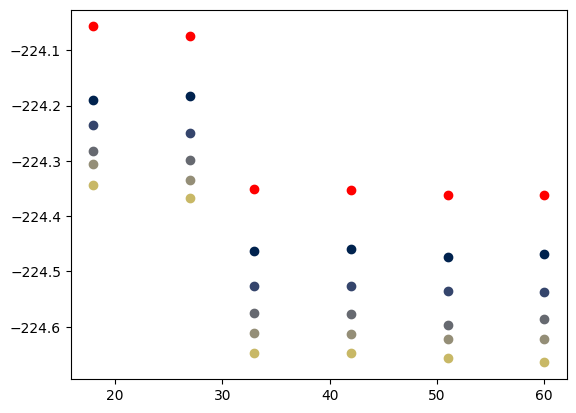

In [71]:
fig, ax = plt.subplots()
n_basis = [len(r["mol"]._basis["O1"]) * 3 for r in results.values()]
cmap = mpl.colormaps["cividis"]
ax.scatter(x = n_basis, y = [r["RHF"].energy_tot() for r in results.values()], color="red")
ax.scatter(x = n_basis, y = [r["CAS(4,4)SCF"].e_tot for r in results.values()], color=cmap(0.0))
ax.scatter(x = n_basis, y = [r["CAS(6,6)SCF"].e_tot for r in results.values()], color=cmap(0.2))
ax.scatter(x = n_basis, y = [r["CAS(8,8)SCF"].e_tot for r in results.values()], color=cmap(0.4))
ax.scatter(x = n_basis, y = [r["CAS(10,10)SCF"].e_tot for r in results.values()], color=cmap(0.6))
ax.scatter(x = n_basis, y = [r["CAS(12,12)SCF"].e_tot for r in results.values()], color=cmap(0.8))

Some observations:
* For a couple of cases, e.g. (4,4) for all three and (8,8) for quadruple zeta, adding diffuse functions leads to a solution with higher energy than the case without diffuse functions. This probably means that the solver has converged to an incorrect state - could check this by looking at the excited states and checking for negative excitations.
* Active space size has a similar impact on all cases